In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [42]:
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve, precision_score, recall_score, f1_score, 
                            roc_auc_score, average_precision_score)

In [43]:
df=pd.read_csv("meta_train.csv")
df.head()

,meta_feature_0,meta_feature_1,target
0,0.000006,5.319346e-07,0
1,0.000002,1.918739e-07,0
2,0.000026,2.674685e-06,0
3,0.000003,2.140096e-07,0
4,0.000016,1.112517e-06,0


In [44]:
df.info

<bound method DataFrame.info of         meta_feature_0  meta_feature_1  target
0             0.000006    5.319346e-07       0
1             0.000002    1.918739e-07       0
2             0.000026    2.674685e-06       0
3             0.000003    2.140096e-07       0
4             0.000016    1.112517e-06       0
...                ...             ...     ...
227840        0.000003    1.513517e-07       0
227841        0.000005    1.111946e-06       0
227842        0.000007    4.212448e-07       0
227843        0.000015    5.460467e-07       0
227844        0.000007    2.636628e-07       0

[227845 rows x 3 columns]>

In [45]:
df.describe()

,meta_feature_0,meta_feature_1,target
count,2.278450e+05,2.278450e+05,227845.000000
mean,1.661948e-03,1.573529e-03,0.001729
std,3.891619e-02,3.874051e-02,0.041548
min,7.282034e-07,1.168590e-08,0.000000
25%,4.758037e-06,3.207808e-07,0.000000
50%,8.434969e-06,7.992193e-07,0.000000
75%,1.842798e-05,2.378185e-06,0.000000
max,9.999973e-01,9.999998e-01,1.000000


In [46]:
df['target'].value_counts(normalize=True)*100

target
0    99.827075
1     0.172925
Name: proportion, dtype: float64

In [92]:
X=df.drop('target',axis=1)
y=df['target']
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [96]:
y_train_res.value_counts()

target
0    181961
1    181961
Name: count, dtype: int64

In [48]:
X_train.mean() #before

meta_feature_0    0.001686
meta_feature_1    0.001587
dtype: float64

In [97]:
#Scalling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train_res)
X_test=scaler.transform(X_test)

In [102]:
X_train.shape

(363922, 2)

In [105]:
X_train_res.shape
y_train=y_train_res

In [107]:
y_train.value_counts()

target
0    181961
1    181961
Name: count, dtype: int64

In [108]:
# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

In [109]:
callback=EarlyStopping(monitor='val_auprc', min_delta=0.02, patience=5, verbose=1, 
                       mode='max', baseline=None, restore_best_weights=False )

In [110]:
model=Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

C:\Users\dhruv\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
model.compile(optimizer=Adam(learning_rate=0.03), loss="binary_crossentropy", metrics=[ tf.keras.metrics.AUC(curve='PR', name='auprc')])

In [114]:
history=model.fit(X_train,y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight={0:1, 1:10},
                  verbose=1, callbacks=callback)

Epoch 1/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - auprc: 0.9339 - loss: 0.8999 - val_auprc: 1.0000 - val_loss: 0.1460
Epoch 2/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - auprc: 0.9363 - loss: 0.8674 - val_auprc: 1.0000 - val_loss: 0.0504
Epoch 3/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - auprc: 0.9372 - loss: 0.8607 - val_auprc: 1.0000 - val_loss: 0.1578
Epoch 4/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - auprc: 0.9396 - loss: 0.8488 - val_auprc: 1.0000 - val_loss: 0.9764
Epoch 5/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - auprc: 0.9365 - loss: 0.9510 - val_auprc: 1.0000 - val_loss: 0.1553
Epoch 6/50
4550/4550 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - auprc: 0.9332 - loss: 0.8857 - val_auprc: 1.0000 - val_loss: 0.1197
Epoch 6: early stopping


In [116]:
y_pred_prob_nn = model.predict(X_test).ravel()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# ROC-AUC
roc_auc_nn = roc_auc_score(y_test, y_pred_prob_nn)
print(f"ROC-AUC Score:{roc_auc_nn:.4f}")

# Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_nn)
auprc_nn= auc(recall, precision)
print(f"AUPRC Score: {auprc_nn:.4f}")

1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.54      0.85      0.66        79

    accuracy                           1.00     45569
   macro avg       0.77      0.92      0.83     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
 [[45434    56]
 [   12    67]]
ROC-AUC Score:0.9727
AUPRC Score: 0.8440


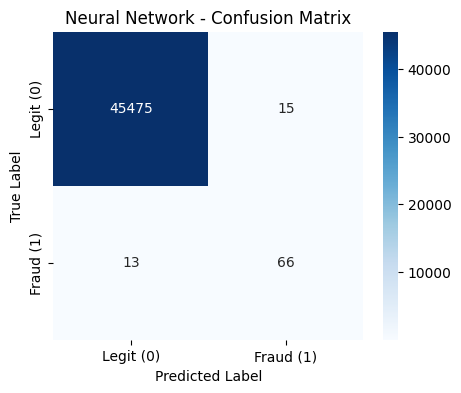

In [56]:
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit (0)", "Fraud (1)"],
            yticklabels=["Legit (0)", "Fraud (1)"])
plt.title("Neural Network - Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [117]:
import keras_tuner as kt

In [134]:
#learning rate 
def build_model(hp):
    model=Sequential()
    units=hp.Int('units', min_value=8, max_value=128, step=8)
    model.add(Dense(units=units, activation='relu', input_dim=2))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer=Adam(learning_rate=0.03),
                  loss="binary_crossentropy", metrics=[ tf.keras.metrics.AUC(curve='PR', name='auprc')])

    return model

In [142]:
tuner=kt.RandomSearch(build_model, objective=kt.Objective("val_auprc", direction="max")
                  , max_trials=3, directory='mydir', project_name='neuuuurons',
                  executions_per_trial=1, overwrite=True)


In [143]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 3 Complete [00h 01m 34s]
val_auprc: 0.0017336346209049225

Best val_auprc So Far: 0.0017336346209049225
Total elapsed time: 00h 04m 44s


In [144]:
tuner.get_best_hyperparameters()[0].values

{'units': 40}